# Global indicator project - Phoenix, Arizona

## OSM street network
Using OpenStreetMap as a source for 
* place boundary
* complete road network
* a pedestrian 'walk' network
* a cycle lane 'bike' network
* calculating street network stats
* calculating intersection density for the pedestrian network


In [1]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import fiona
import pandas as pd

ox.config(use_cache=True, log_console=True)
ox.__version__

'0.9'

## Get place boundary

In [2]:
suffix = '_201905'

places = ['Phoenix, Arizona, USA']

In [19]:
def studyregion(address):
    G = ox.gdf_from_place(address)
    ox.save_gdf_shapefile(G, filename='{studyregion}_shape{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../data/OSM')
    return G

In [20]:
def studyregion_buffered(address):
    G = ox.gdf_from_place(address, buffer_dist=1e4)
    ox.save_gdf_shapefile(G, filename='{studyregion}_buffered{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../data/OSM')
    return G


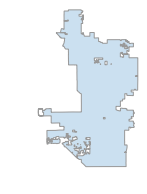

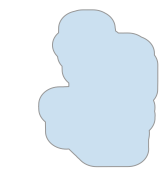

In [21]:
for address in places:
    studyregion = studyregion(address)
    studyregion_buffer = studyregion_buffered(address)
    ox.plot_shape(studyregion, figsize=(3,3))
    ox.plot_shape(studyregion_buffer, figsize=(3,3))

## Get complete street network and pedestrain network

In [22]:
# Extract complete OSM network: "all (non-private) OSM streets and paths"

def OSM_all(address):    
    #studyregion = studyregion_buffered(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_all = ox.graph_from_polygon(polygon, network_type= 'all', retain_all = True)
    #W_all = ox.graph_from_address(address, network_type= 'all', retain_all = True)

    W_all = ox.graph_from_place(address, network_type= 'all', retain_all = True, buffer_dist=1e4)
    ox.save_graphml(W_all, filename='{studyregion}_all{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../data/OSM')
    W_all_proj = ox.project_graph(W_all)
    W_proj_gdfs = ox.graph_to_gdfs(W_all_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    #show network figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = W_proj_gdfs.plot(ax=ax)
    ax.set_title(address)
    ax.set_axis_off()
    fig.suptitle('All OSM street network', fontsize=14, fontweight='bold')
    fig.text(0.1, 0, 'Note: all non-private street network')
    plt.show()



In [ ]:
# Extract pedestrain OSM network
def OSM_walk(address):
    #studyregion = studyregion_shape(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_walk = ox.graph_from_polygon(polygon, network_type= 'walk')
    
    #W_walk = ox.graph_from_address(address, network_type= 'walk')
    W_walk = ox.graph_from_place(address, network_type= 'walk', retain_all=True, buffer_dist=1e4)
    ox.save_graphml(W_walk, filename='{studyregion}_walk{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../data/OSM')
    
    W_walk_proj = ox.project_graph(W_walk)
    W_proj_gdfs = ox.graph_to_gdfs(W_walk_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    #show network figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = W_proj_gdfs.plot(ax=ax)
    ax.set_title(address)
    ax.set_axis_off()
    fig.suptitle('All OSM pedestrain network', fontsize=14, fontweight='bold')
    fig.text(0.1, 0, 'Note: based on OSMnx walk network type')
    plt.show()



In [ ]:
# Extract cycle OSM network
def OSM_bike(address):
    #studyregion = studyregion_shape(address)
    #polygon = studyregion['geometry'].iloc[0]
    #W_walk = ox.graph_from_polygon(polygon, network_type= 'walk')
    
    #W_walk = ox.graph_from_address(address, network_type= 'walk')
    W_walk = ox.graph_from_place(address, network_type= 'bike', retain_all=True, buffer_dist=1e4)
    ox.save_graphml(W_walk, filename='{studyregion}_bike{suffix}.graphml'.format(studyregion = address,
                                                                                   suffix = suffix), folder='../data/OSM')
    
    W_walk_proj = ox.project_graph(W_walk)
    W_proj_gdfs = ox.graph_to_gdfs(W_walk_proj, nodes=False, edges=True, fill_edge_geometry=True)
    
    #show network figure
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = W_proj_gdfs.plot(ax=ax)
    ax.set_title(address)
    ax.set_axis_off()
    fig.suptitle('All OSM pedestrain network', fontsize=14, fontweight='bold')
    fig.text(0.1, 0, 'Note: based on OSMnx bike network type')
    plt.show()

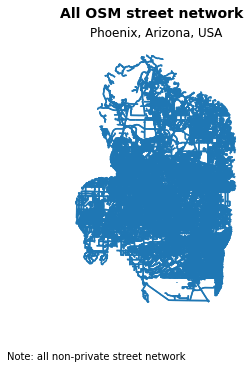

In [ ]:
for address in places:
    OSM_all(address)

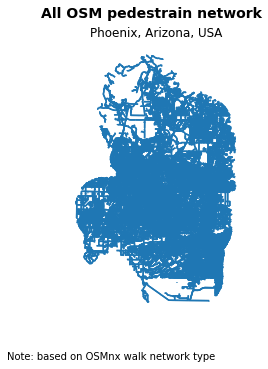

In [ ]:
for address in places:
    OSM_walk(address)

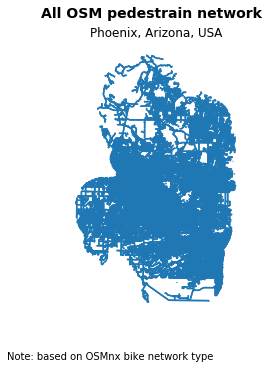

In [ ]:
for address in places:
    OSM_bike(address)

### OSM network stats
Note: may be helpful to think which stats to keep for indicator calculation and compare accross places

In [4]:
def OSM_stats(address):
    df = pd.DataFrame()
    for networktype in ['all', 'walk', 'bike']:
        w = ox.graph_from_place(address, network_type=networktype, retain_all=True, buffer_dist=1e4)
        w_proj = ox.project_graph(w)
    
        nodes_proj = ox.graph_to_gdfs(w_proj, edges=False)
        graph_area_m = nodes_proj.unary_union.convex_hull.area
    
        stats = ox.basic_stats(w_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean', tolerance=15)
        df1 = pd.DataFrame.from_dict(stats, orient='index', columns=[networktype + address])
        df = pd.concat([df, df1], axis=1)
    return df

In [5]:
stats = OSM_stats('Phoenix, Arizona, USA')
stats

,"allPhoenix, Arizona, USA","walkPhoenix, Arizona, USA","bikePhoenix, Arizona, USA"
n,256606,252049,227584
m,681535,714888,606269
k_avg,5.31192,5.67261,5.32787
intersection_count,219145,214235,194255
streets_per_node_avg,2.83841,2.83928,2.84806
streets_per_node_counts,"{0: 0, 1: 37461, 2: 7126, 3: 172725, 4: 38102,...","{0: 0, 1: 37814, 2: 5106, 3: 170467, 4: 37204,...","{0: 0, 1: 33329, 2: 2476, 3: 158383, 4: 32313,..."
streets_per_node_proportion,"{0: 0.0, 1: 0.14598645394106138, 2: 0.02777020...","{0: 0.0, 1: 0.15002638375871358, 2: 0.02025796...","{0: 0.0, 1: 0.14644702615298089, 2: 0.01087949..."
edge_length_total,6.36578e+07,6.53237e+07,5.81984e+07
edge_length_avg,93.4035,91.3762,95.9944
street_length_total,3.46511e+07,3.30357e+07,3.12672e+07


## Clean intersections

Note: this code is adopted from 'OSMNX intersection tuning.ipynb'

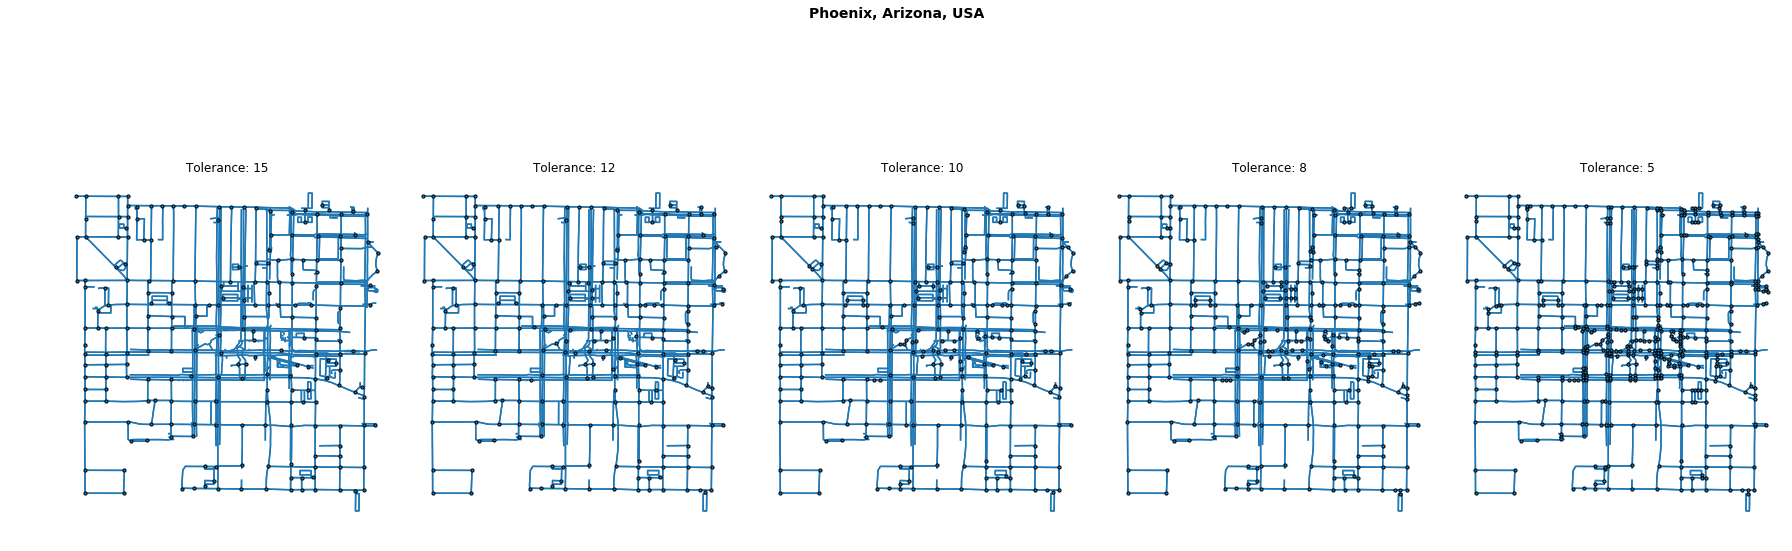

In [3]:
def OSM_clean_intersection(address):
    G = ox.graph_from_address(address, network_type= 'walk', distance=750)
    G_proj = ox.project_graph(G)
    G_proj_gdfs = ox.graph_to_gdfs(G_proj, nodes=False, edges=True, fill_edge_geometry=True)
    #itereate over cleaning buffer distance
    buffers = [15,12,10,8,5]
    # instantiate plot
    fig, axarr = plt.subplots(ncols=5, sharex='col', sharey='row', squeeze=False, figsize=(25,10))
    for i in range(len(buffers)):
        # clean up the intersections and extract their xy coords
        intersections = ox.clean_intersections(G_proj, tolerance=buffers[i], dead_ends=False)
        points = np.array([point.xy for point in intersections])
        # plot the cleaned-up intersections
        G_proj_gdfs.plot(ax = axarr[0][i])
        axarr[0][i].scatter(x=points[:,0], y=points[:,1], s = 10, zorder=2, color=None, edgecolors='#000000')
        axarr[0][i].set_title("Tolerance: {}".format(buffers[i]))
        axarr[0][i].set_aspect(1)
        axarr[0][i].set_axis_off()
        # axarr[0][i].add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2))
    plt.suptitle(address, fontsize=14, fontweight='bold')    
    plt.tight_layout()
    plt.show()
    return intersections

for address in places:
    OSM_clean_intersection(address)

Idea (from Carl): Could be interesting to overlay modified tolerances with some kind of image difference overlay relative to original (e.g. colourize where nodes have been added or subtracted)